# 04 - Modelling

In [1]:
!pip install keras-tuner -q

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import shutil
import cv2;

2023-06-29 15:54:56.609501: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [56]:
from keras import models, layers, regularizers
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator;

from keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras_tuner import RandomSearch, GridSearch 

In [3]:
import matplotlib.pyplot as plt

In [4]:
from sklearn.dummy import DummyClassifier

In [5]:
import kerastuner.tuners as kt

/var/folders/mh/9l7f5q2x0bsc05929xvm2nnh0000gn/T/ipykernel_16369/982218236.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner.tuners as kt


# 1.0 Importing data

In [6]:
interim_path = '/Users/chinmayasukumar/Documents/Springboard/Capstone-3_Classifying_Steel_Defects/data/interim/'

In [7]:
# Loading images from preprocessing stage
images = np.load(interim_path + 'images.npy')

In [8]:
# Loading Dataframe of labels
df = pd.read_csv(interim_path + 'data.csv')

In [9]:
# One Hot Encoding labels
df = pd.get_dummies(df, columns=['Type'])

In [10]:
df.head()

,Filename,Number,Type_Crazing,Type_Inclusions,Type_Patches,Type_Pitted,Type_Rolled,Type_Scratches
0,Cr_1.bmp,1,1,0,0,0,0,0
1,Cr_10.bmp,10,1,0,0,0,0,0
2,Cr_100.bmp,100,1,0,0,0,0,0
3,Cr_101.bmp,101,1,0,0,0,0,0
4,Cr_102.bmp,102,1,0,0,0,0,0


In [11]:
# Creating labels, converting to array
labels = df.iloc[:,2:].to_numpy()

In [12]:
# Confirming shape of labels
labels.shape

(1800, 6)

In [13]:
labels

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]], dtype=uint8)

In [14]:
# Confirming shape of images
images.shape

(1800, 200, 200)

In [16]:
# Setting random seed
keras.utils.set_random_seed(132)

#### There are 1800 200x200 images with 6 possible categories corresponding to the type of steel defect

# 2.0 Model selection

## 2.1 Splitting Data

In [17]:
# Reshape images to (1800, 200, 200, 1) to account for black/white channel
images = images.reshape(-1,200,200,1)

In [18]:
# Splitting into train and (test, valid) sets to be split further
X_train, X_test_val, y_train, y_test_val = train_test_split(images, labels, test_size=0.3)

# Splitting (test, valid) set into seperate test and valid sets
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

In [19]:
# Checking shapes
(X_train.shape, X_test.shape, X_val.shape)

((1260, 200, 200, 1), (270, 200, 200, 1), (270, 200, 200, 1))

In [20]:
# Checking shapes
(y_train.shape, y_test.shape, y_val.shape)

((1260, 6), (270, 6), (270, 6))

## 2.2 Dummy Classifier

#### Setting dummy classifier to set benchmark for evaluating real models

In [21]:
# Insantiating a Dummy Classifier
dummy = DummyClassifier()

In [22]:
# Fitting to training set
dummy.fit(X_train, y_train)

DummyClassifier()

In [23]:
# Getting predictions
y_pred = dummy.predict(X_test)

In [24]:
# Converting from one-hot encoded
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

In [25]:
print(classification_report(y_test_classes, y_pred_classes, zero_division=False))

              precision    recall  f1-score   support

           0       0.14      1.00      0.25        39
           1       0.00      0.00      0.00        48
           2       0.00      0.00      0.00        41
           3       0.00      0.00      0.00        53
           4       0.00      0.00      0.00        50
           5       0.00      0.00      0.00        39

    accuracy                           0.14       270
   macro avg       0.02      0.17      0.04       270
weighted avg       0.02      0.14      0.04       270



## 2.3 ResNet

In [36]:
# Fits model to training data (input) and validates on valuation data
# Restores best weights
# Returns history

model_path = '/Users/chinmayasukumar/Documents/Springboard/Capstone-3_Classifying_Steel_Defects/models/'

def train_model(model, X_train, y_train, X_val, y_val, checkpoint_path):
    
    model.compile(optimizer=Adam(),\
                  loss='categorical_crossentropy',\
                  metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint(model_path + checkpoint_path,\
                                 monitor='val_loss', 
                                 save_best_model=True, \
                                 save_weights_only=True)
    
    history = model.fit(X_train, y_train,\
                        epochs=15, \
                        validation_data=(X_val, y_val),\
                        callbacks=[checkpoint])
    
    return history

In [27]:
# Creating ResNet model
# input_tensor has shape (200, 200, 3) since ResNet only takes RGB images
# include_top = False since classification problem is small

res_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(200,200,3)))

### Transforming Grayscale to RGB

In [28]:
# Simulating images so they appear RGB
# np.repeat repeats X_train's last column which is the column added for grayscale
X_train_rgb = np.repeat(X_train,3,-1)
X_test_rgb = np.repeat(X_test,3,-1)
X_val_rgb = np.repeat(X_val,3,-1)

In [29]:
X_train_rgb.shape, X_test_rgb.shape, X_val_rgb.shape

((1260, 200, 200, 3), (270, 200, 200, 3), (270, 200, 200, 3))

In [30]:
y_train.shape, y_test.shape, y_val.shape

((1260, 6), (270, 6), (270, 6))

### Training ResNet

In [32]:
x = layers.GlobalAveragePooling2D()(res_model.output)

output = layers.Dense(6, activation='softmax')(x)

res_model = Model(inputs=res_model.input, outputs=output)

for layer in res_model.layers:
    layer.trainable = False

res_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

train_model(res_model, X_train_rgb, y_train, X_val_rgb, y_val, 'resnet/resnet_checkpoint.h5')

Epoch 1/15
40/40 [==============================] - 120s 3s/step - loss: 2.1238 - accuracy: 0.1008 - val_loss: 2.0985 - val_accuracy: 0.0778
Epoch 2/15
40/40 [==============================] - 115s 3s/step - loss: 2.1238 - accuracy: 0.1008 - val_loss: 2.0985 - val_accuracy: 0.0778
Epoch 3/15
40/40 [==============================] - 113s 3s/step - loss: 2.1238 - accuracy: 0.1008 - val_loss: 2.0985 - val_accuracy: 0.0778
Epoch 4/15
40/40 [==============================] - 112s 3s/step - loss: 2.1238 - accuracy: 0.1008 - val_loss: 2.0985 - val_accuracy: 0.0778
Epoch 5/15
40/40 [==============================] - 112s 3s/step - loss: 2.1238 - accuracy: 0.1008 - val_loss: 2.0985 - val_accuracy: 0.0778
Epoch 6/15
40/40 [==============================] - 113s 3s/step - loss: 2.1238 - accuracy: 0.1008 - val_loss: 2.0985 - val_accuracy: 0.0778
Epoch 7/15
40/40 [==============================] - 112s 3s/step - loss: 2.1238 - accuracy: 0.1008 - val_loss: 2.0985 - val_accuracy: 0.0778
Epoch 8/15
40

KeyboardInterrupt: 

### Evaluating ResNet

In [ ]:
# Getting predictions
y_pred_res = res_model.predict(X_test_rgb)

In [ ]:
# Getting classes of predictions
y_pred_classes = np.argmax(y_pred_res, axis=1)

In [ ]:
# Test classes
y_test_classes = np.argmax(y_test, axis=1)

In [ ]:
# Confusion matrix
print(confusion_matrix(y_test_classes, y_pred_classes))

In [ ]:
# Getting classification report with labels
labels_ = ['Crazing', 'Inclusions', 'Patches', 'Pitted', 'Rolled', 'Scratches']
print(classification_report(y_test_classes, y_pred_classes, target_names=labels_));

#### This model will be put on hold while CNN is tested

### Saving model

## 2.4 CNN

In [37]:
# Creates a CNN model and returns it

def create_model():    
    model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 1)),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dense(6, activation='softmax')
            ])
    
    return model

In [38]:
# Instantiating base CNN model

base_cnn = create_model();

In [39]:
# Training model 
# Instantiating hist_base_cnn as the history returned from the train_model function

hist_base_cnn = train_model(base_cnn, X_train, y_train, X_val, y_val, \
'base_cnn/base_cnn_checkpoint.h5')

Epoch 1/15
40/40 [==============================] - 43s 1s/step - loss: 1.5155 - accuracy: 0.3103 - val_loss: 0.9896 - val_accuracy: 0.5963
Epoch 2/15
40/40 [==============================] - 59s 1s/step - loss: 0.8529 - accuracy: 0.6429 - val_loss: 0.6828 - val_accuracy: 0.7741
Epoch 3/15
40/40 [==============================] - 51s 1s/step - loss: 0.4972 - accuracy: 0.8262 - val_loss: 0.4298 - val_accuracy: 0.8481
Epoch 4/15
40/40 [==============================] - 66s 2s/step - loss: 0.4149 - accuracy: 0.8484 - val_loss: 0.4709 - val_accuracy: 0.8185
Epoch 5/15
40/40 [==============================] - 62s 2s/step - loss: 0.3913 - accuracy: 0.8508 - val_loss: 0.3337 - val_accuracy: 0.8704
Epoch 6/15
40/40 [==============================] - 67s 2s/step - loss: 0.3414 - accuracy: 0.8770 - val_loss: 0.9478 - val_accuracy: 0.6370
Epoch 7/15
40/40 [==============================] - 70s 2s/step - loss: 0.3572 - accuracy: 0.8810 - val_loss: 0.2816 - val_accuracy: 0.8963
Epoch 8/15
40/40 [==

In [40]:
# Function that accepts trial history and a title
# Returns model accuracy and loss in both train and validation sets
def grapher(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    fig.suptitle(title, fontsize=16)

    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

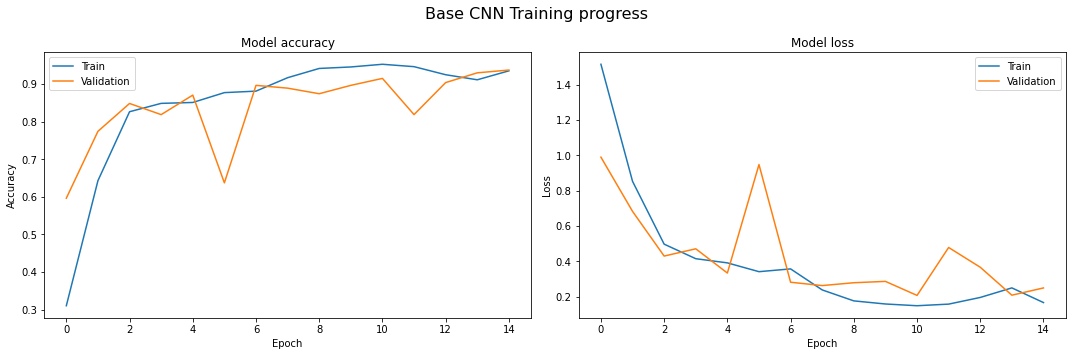

In [41]:
grapher(hist_base_cnn, 'Base CNN Training progress')

### Evaluating CNN

In [42]:
# Building a function to predict and evaluate on Test set
# Returns confusion matrix and classification report

labels_ = ['Crazing', 'Inclusions', 'Patches', 'Pitted', 'Rolled', 'Scratches']

def predictor(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    print('\n')
    print('   Confusion matrix')
    print('\n')
    print(confusion_matrix(y_test_classes, y_pred_classes))
    print('\n')
    print('                 Classification report')
    print('\n')
    print(classification_report(y_test_classes, y_pred_classes, target_names=labels_))
    return classification_report(y_test_classes, y_pred_classes, target_names=labels_, output_dict=True)

In [44]:
base_cnn_path = model_path + 'base_cnn/base_cnn_checkpoint.h5'
base_cnn.load_weights(base_cnn_path)

In [45]:
predictor(base_cnn, X_test, y_test);

9/9 [==============================] - 3s 306ms/step


   Confusion matrix


[[38  0  1  0  0  0]
 [ 0 44  0  4  0  0]
 [ 2  0 38  0  1  0]
 [ 0  7  0 42  2  2]
 [ 0  0  0  0 50  0]
 [ 0  4  0  0  0 35]]


                 Classification report


              precision    recall  f1-score   support

     Crazing       0.95      0.97      0.96        39
  Inclusions       0.80      0.92      0.85        48
     Patches       0.97      0.93      0.95        41
      Pitted       0.91      0.79      0.85        53
      Rolled       0.94      1.00      0.97        50
   Scratches       0.95      0.90      0.92        39

    accuracy                           0.91       270
   macro avg       0.92      0.92      0.92       270
weighted avg       0.92      0.91      0.91       270



#### Inclusions, Patches, Pits and Scratches aren't classified properly

#### Classes Crazing, Pitted and Scratches don't have very good f1-scores

In [51]:
base_cnn.save(model_path + 'base_cnn/final_base_cnn.h5')

## 3.0 Hyperparameter tuning

## 3.1  Round 1

In [52]:
# Creating another CNN for hyperparameter tuning
# Learning rate and optimizers (Adam or SGD) will be chosen as hyperparameters

def create_model_1(hp):
    model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 1)),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dense(6, activation='softmax'),
            ])

    # Optimizer can be changed
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    
    # Learning rate can be changed
    learning_rate = hp.Float('learning_rate', 0.0001, 0.0151, sampling='log')

    # Conditional statement depending on which optimzier is chosen during Random Search
    if optimizer == 'adam':
        model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy',\
        metrics=['accuracy'])
    # If the chosen optimizer is SGD, the model will use a SGD with whichever learning rate is chosen
    else:
        model.compile(optimizer=keras.optimizers.SGD(learning_rate), loss='categorical_crossentropy',\
            metrics=['accuracy'])

    return model

In [77]:
# Creating RandomSearch object 
tuner_1 = RandomSearch(create_model_1, objective='val_accuracy', max_trials=15, executions_per_trial=1,
                       directory=model_path + 'tuner_dir/',
                       project_name='tuner_round_1',
                       overwrite=True); 

In [75]:
# Random Search value range
tuner_1.search_space_summary()

Search space summary
Default search space size: 2
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd'], 'ordered': False}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.0151, 'step': None, 'sampling': 'log'}


In [72]:
# Verifying shapes
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1260, 200, 200, 1), (1260, 6), (270, 200, 200, 1), (270, 6))

In [80]:
tuner_1_stop = EarlyStopping(monitor='val_loss',
                    # 3 epochs to improve val_loss
                    patience=3,
                    mode='min',
                    restore_best_weights=True,
                    verbose=1,\
                    start_from_epoch=5)

tuner_1_logs = CSVLogger(model_path + 'tuner_dir/tuner_round_1/tuner_1_logs.csv')

In [81]:
# Running Random Search
tuner_1.search(X_train, y_train, \
               epochs=15, \
               validation_data=(X_val, y_val), \
               callbacks=[tuner_1_stop, tuner_1_logs])

Trial 11 Complete [00h 13m 23s]
val_accuracy: 0.7074074149131775

Best val_accuracy So Far: 0.9333333373069763
Total elapsed time: 01h 50m 07s

Search: Running Trial #12

Value             |Best Value So Far |Hyperparameter
sgd               |adam              |optimizer
0.00049207        |0.0016339         |learning_rate

Epoch 1/15
40/40 [==============================] - 52s 1s/step - loss: 1.7912 - accuracy: 0.1317 - val_loss: 1.7896 - val_accuracy: 0.1407
Epoch 2/15
37/40 [==========================>...] - ETA: 4s - loss: 1.7876 - accuracy: 0.1199

KeyboardInterrupt: 

In [143]:
first_1, second_1, third_1, fourth_1, fifth_1 = tuner_1.get_best_models(5)

In [320]:
tuner_1.results_summary()

Results summary
Results in /Users/chinmayasukumar/Documents/Springboard/Capstone 3 - Metal defect detection/models/tuner_dir/tuner_round_1
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 04 summary
Hyperparameters:
optimizer: adam
learning_rate: 0.0014480885322464736
Score: 0.9407407641410828

Trial 00 summary
Hyperparameters:
optimizer: adam
learning_rate: 0.0010767154199577559
Score: 0.9185185432434082

Trial 10 summary
Hyperparameters:
optimizer: adam
learning_rate: 0.0005033243136566849
Score: 0.9185185432434082

Trial 01 summary
Hyperparameters:
optimizer: adam
learning_rate: 0.0003859743262681973
Score: 0.9037036895751953

Trial 05 summary
Hyperparameters:
optimizer: sgd
learning_rate: 0.010684564575305484
Score: 0.47777777910232544

Trial 08 summary
Hyperparameters:
optimizer: sgd
learning_rate: 0.005534159104865749
Score: 0.4481481611728668

Trial 07 summary
Hyperparameters:
optimizer: sgd
learning_rate: 0.00734188628956296
Score: 0.374074071645736

In [419]:
tuner_1.oracle.get_best_trials(4)

### Model #1 Round 1

In [279]:
# Evaluating first model on test set and saving metrics dictionary
model_1_1_metrics = predictor(first_1, X_test, y_test, True)

9/9 [==============================] - 3s 332ms/step


   Confusion matrix


[[39  0  0  0  0  0]
 [ 0 51  0  1  0  0]
 [ 2  0 39  0  0  0]
 [ 0  3  0 45  0  1]
 [ 0  0  0  1 49  0]
 [ 0  0  0  3  0 36]]


                 Classification report


              precision    recall  f1-score   support

     Crazing       0.95      1.00      0.97        39
  Inclusions       0.94      0.98      0.96        52
     Patches       1.00      0.95      0.97        41
      Pitted       0.90      0.92      0.91        49
      Rolled       1.00      0.98      0.99        50
   Scratches       0.97      0.92      0.95        39

    accuracy                           0.96       270
   macro avg       0.96      0.96      0.96       270
weighted avg       0.96      0.96      0.96       270



In [318]:
model_1_1_metrics['accuracy']

0.9592592592592593

### Model #2 Round 1 

In [289]:
# Evaluating second model on test set
model_2_1_metrics = predictor(second_1, X_test, y_test)

9/9 [==============================] - 3s 350ms/step


   Confusion matrix


[[39  0  0  0  0  0]
 [ 0 51  0  0  0  1]
 [ 3  0 38  0  0  0]
 [ 0 12  0 31  0  6]
 [ 0  0  0  0 50  0]
 [ 0  4  0  1  0 34]]


                 Classification report


              precision    recall  f1-score   support

     Crazing       0.93      1.00      0.96        39
  Inclusions       0.76      0.98      0.86        52
     Patches       1.00      0.93      0.96        41
      Pitted       0.97      0.63      0.77        49
      Rolled       1.00      1.00      1.00        50
   Scratches       0.83      0.87      0.85        39

    accuracy                           0.90       270
   macro avg       0.91      0.90      0.90       270
weighted avg       0.91      0.90      0.90       270



In [323]:
model_2_1_metrics['accuracy']

0.9

### Model #3 Round 1

In [290]:
# Evaluating third model on test set
model_3_1_metrics = predictor(third_1, X_test, y_test)

9/9 [==============================] - 4s 447ms/step


   Confusion matrix


[[38  0  1  0  0  0]
 [ 0 51  0  0  0  1]
 [ 9  0 32  0  0  0]
 [ 0  9  0 37  0  3]
 [ 1  0  0  0 49  0]
 [ 0  1  0  0  0 38]]


                 Classification report


              precision    recall  f1-score   support

     Crazing       0.79      0.97      0.87        39
  Inclusions       0.84      0.98      0.90        52
     Patches       0.97      0.78      0.86        41
      Pitted       1.00      0.76      0.86        49
      Rolled       1.00      0.98      0.99        50
   Scratches       0.90      0.97      0.94        39

    accuracy                           0.91       270
   macro avg       0.92      0.91      0.90       270
weighted avg       0.92      0.91      0.91       270



### Model #4 Round 1

In [291]:
# Evaluating third model on test set
model_4_1_metrics = predictor(fourth_1, X_test, y_test)

9/9 [==============================] - 3s 375ms/step


   Confusion matrix


[[38  0  1  0  0  0]
 [ 0 44  0  4  0  4]
 [ 5  0 36  0  0  0]
 [ 0  6  0 40  0  3]
 [ 0  0  0  0 50  0]
 [ 0  1  0  2  2 34]]


                 Classification report


              precision    recall  f1-score   support

     Crazing       0.88      0.97      0.93        39
  Inclusions       0.86      0.85      0.85        52
     Patches       0.97      0.88      0.92        41
      Pitted       0.87      0.82      0.84        49
      Rolled       0.96      1.00      0.98        50
   Scratches       0.83      0.87      0.85        39

    accuracy                           0.90       270
   macro avg       0.90      0.90      0.90       270
weighted avg       0.90      0.90      0.90       270



### Model #5 Round 1

In [292]:
metrics_5_1_metrics = predictor(fifth_1, X_test, y_test)

9/9 [==============================] - 4s 419ms/step


   Confusion matrix


[[33  1  0  0  4  1]
 [ 4 12  0  0 17 19]
 [24  0 15  0  1  1]
 [38  0  0  0  4  7]
 [ 5  3  0  0 30 12]
 [ 2  0  0  1 11 25]]


                 Classification report


              precision    recall  f1-score   support

     Crazing       0.31      0.85      0.46        39
  Inclusions       0.75      0.23      0.35        52
     Patches       1.00      0.37      0.54        41
      Pitted       0.00      0.00      0.00        49
      Rolled       0.45      0.60      0.51        50
   Scratches       0.38      0.64      0.48        39

    accuracy                           0.43       270
   macro avg       0.48      0.45      0.39       270
weighted avg       0.48      0.43      0.38       270



In [238]:
def make_table(tuner, round_number, multiple_optimizers=True):
    # Metrics to be evaluated
    metrics = ['accuracy', 'loss', 'val_accurcy', 'val_loss']
    
    # Instantiating empty lists
    trial_list  = list()
    lr = list()
    opt = list()
    acc = list()
    loss = list()
    val_acc = list()
    val_loss = list()
    
    # Metric names to be used 
    metrics = ['accuracy', 'loss', 'val_accuracy', 'val_loss']
    
    # List of metric tables
    metrics_list = [acc, loss, val_acc, val_loss]
    
    # Looping through all the trials
    for trial in tuner.oracle.get_best_trials(14):
        
        # Appending trial info to corresponding tables
        trial_list.append(trial.trial_id)

        lr.append(trial.hyperparameters.values['learning_rate'])
        if multiple_optimizers:
            opt.append(trial.hyperparameters.values['optimizer'])
        else:
            opt = ['adam' for i in range(14)]
    
        # Appending metric to corresponding tables
        for m, metric in zip(metrics_list, metrics):
            m.append(trial.metrics.get_history(metric)[0].value[0])
    
    # Combining list into DataFrame
    results = pd.DataFrame({'Trial Number':trial_list,
                            'Round':str(round_number),
                            'Learning rate':lr,
                            'Optimizer':opt,
                            'Accuracy':acc,
                            'Loss':loss,
                            'Val accuracy':val_acc,
                            'Val loss':val_loss})
    
    return results

In [240]:
trials_1 = make_table(tuner_1,1)
trials_1

,Trial Number,Round,Learning rate,Optimizer,Accuracy,Loss,Val accuracy,Val loss
0,04,1,0.001448,adam,0.939683,0.204120,0.940741,0.209473
1,00,1,0.001077,adam,0.914286,0.235974,0.918519,0.251491
2,10,1,0.000503,adam,0.928571,0.184521,0.918519,0.243937
3,01,1,0.000386,adam,0.901587,0.279056,0.903704,0.248355
4,05,1,0.010685,sgd,0.530159,1.246183,0.477778,1.253679
5,08,1,0.005534,sgd,0.420635,1.453452,0.448148,1.400778
6,07,1,0.007342,sgd,0.465079,1.373682,0.374074,1.402330
7,13,1,0.002360,sgd,0.331746,1.623362,0.344444,1.612711
8,12,1,0.000377,sgd,0.219048,1.782488,0.251852,1.780683
9,06,1,0.000336,sgd,0.236508,1.767083,0.207407,1.774436


## 3.2 Final Round

#### The best performing optimizer is Adam

#### The best performing learning rate in the first search was ~0.00037. 

#### The accuracy seems to increase below this level so a Grid Search will be done to find the optimal optimization value using an Adam optimizer

In [178]:
# Creating new model with Adam optimizer and tuning for learning rate only
def create_model_2(hp):
    model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 1)),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dense(6, activation='softmax')
            ])

    # Learning rate range for Grid Search is listed below
    learning_rate = hp.Float('learning_rate', 0.0003, 0.0031, step=0.0002)
    
    # Adam optimizer is chosen over SGD
    model.compile(optimizer=Adam(learning_rate),loss='categorical_crossentropy',\
            metrics=['accuracy'])
    return model

In [179]:
# A GridSearch object is now generated
# Grid Search used to accurately determine optimal learning rate

tuner_2 = GridSearch(create_model_2, objective='val_accuracy', max_trials=15, executions_per_trial=1, \
                     directory=gen_path + 'tuner_dir', \
                     project_name='tuner_round_2', overwrite=True)

In [180]:
# Searching hyperparameters
tuner_2.search(X_train, y_train, epochs=12, validation_data=(X_val, y_val))

Trial 14 Complete [00h 11m 43s]
val_accuracy: 0.9111111164093018

Best val_accuracy So Far: 0.9518518447875977
Total elapsed time: 02h 16m 33s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [181]:
tuner_2.results_summary()

Results summary
Results in /Users/chinmayasukumar/Documents/Springboard/Capstone 3 - Metal defect detection/models/tuner_dir/tuner_round_2
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 06 summary
Hyperparameters:
learning_rate: 0.0015
Score: 0.9518518447875977

Trial 02 summary
Hyperparameters:
learning_rate: 0.0007
Score: 0.9481481313705444

Trial 01 summary
Hyperparameters:
learning_rate: 0.0005
Score: 0.9370370507240295

Trial 05 summary
Hyperparameters:
learning_rate: 0.0013
Score: 0.9370370507240295

Trial 03 summary
Hyperparameters:
learning_rate: 0.0009
Score: 0.9333333373069763

Trial 04 summary
Hyperparameters:
learning_rate: 0.0011
Score: 0.9296296238899231

Trial 12 summary
Hyperparameters:
learning_rate: 0.0027
Score: 0.9296296238899231

Trial 08 summary
Hyperparameters:
learning_rate: 0.0019
Score: 0.9222221970558167

Trial 09 summary
Hyperparameters:
learning_rate: 0.0021000000000000003
Score: 0.9222221970558167

Trial 00 summary
Hyperparam

In [182]:
first_2, second_2, third_2, fourth_2, fifth_2 = tuner_2.get_best_models(5)

## 4.0 Evaluating best models

### Model #1 Final Round

In [293]:
# Evaluating first model
model_1_2_metrics = predictor(first_2, X_test, y_test)

9/9 [==============================] - 4s 409ms/step


   Confusion matrix


[[38  0  1  0  0  0]
 [ 0 51  0  0  0  1]
 [ 2  0 39  0  0  0]
 [ 0  4  0 44  0  1]
 [ 0  0  0  0 50  0]
 [ 0  1  0  2  0 36]]


                 Classification report


              precision    recall  f1-score   support

     Crazing       0.95      0.97      0.96        39
  Inclusions       0.91      0.98      0.94        52
     Patches       0.97      0.95      0.96        41
      Pitted       0.96      0.90      0.93        49
      Rolled       1.00      1.00      1.00        50
   Scratches       0.95      0.92      0.94        39

    accuracy                           0.96       270
   macro avg       0.96      0.95      0.96       270
weighted avg       0.96      0.96      0.96       270



### Model #2 Final Round

In [294]:
# Evaluating second model
model_2_2_metrics = predictor(second_2, X_test, y_test)

9/9 [==============================] - 2s 259ms/step


   Confusion matrix


[[38  0  1  0  0  0]
 [ 0 50  0  2  0  0]
 [ 2  0 39  0  0  0]
 [ 0  7  0 41  0  1]
 [ 0  0  0  0 50  0]
 [ 0  1  0  2  0 36]]


                 Classification report


              precision    recall  f1-score   support

     Crazing       0.95      0.97      0.96        39
  Inclusions       0.86      0.96      0.91        52
     Patches       0.97      0.95      0.96        41
      Pitted       0.91      0.84      0.87        49
      Rolled       1.00      1.00      1.00        50
   Scratches       0.97      0.92      0.95        39

    accuracy                           0.94       270
   macro avg       0.95      0.94      0.94       270
weighted avg       0.94      0.94      0.94       270



### Model #3 Final Round

In [295]:
# Evaluating third model
model_3_2_metrics = predictor(third_2, X_test, y_test)

9/9 [==============================] - 3s 358ms/step


   Confusion matrix


[[38  0  1  0  0  0]
 [ 0 46  0  6  0  0]
 [ 3  0 38  0  0  0]
 [ 0  2  0 46  0  1]
 [ 0  0  0  3 47  0]
 [ 0  1  0  2  0 36]]


                 Classification report


              precision    recall  f1-score   support

     Crazing       0.93      0.97      0.95        39
  Inclusions       0.94      0.88      0.91        52
     Patches       0.97      0.93      0.95        41
      Pitted       0.81      0.94      0.87        49
      Rolled       1.00      0.94      0.97        50
   Scratches       0.97      0.92      0.95        39

    accuracy                           0.93       270
   macro avg       0.94      0.93      0.93       270
weighted avg       0.93      0.93      0.93       270



### Model #4 Final Round

In [296]:
# Evaluating fourth model
model_4_2_metrics = predictor(fourth_2, X_test, y_test)

9/9 [==============================] - 4s 432ms/step


   Confusion matrix


[[37  0  2  0  0  0]
 [ 0 43  0  4  0  5]
 [ 0  0 41  0  0  0]
 [ 0  0  0 47  0  2]
 [ 0  0  0  0 50  0]
 [ 0  0  0  2  0 37]]


                 Classification report


              precision    recall  f1-score   support

     Crazing       1.00      0.95      0.97        39
  Inclusions       1.00      0.83      0.91        52
     Patches       0.95      1.00      0.98        41
      Pitted       0.89      0.96      0.92        49
      Rolled       1.00      1.00      1.00        50
   Scratches       0.84      0.95      0.89        39

    accuracy                           0.94       270
   macro avg       0.95      0.95      0.94       270
weighted avg       0.95      0.94      0.94       270



### Model #5 Final Round

In [297]:
model_5_2_metrics = predictor(fifth_2, X_test, y_test)

9/9 [==============================] - 4s 430ms/step


   Confusion matrix


[[39  0  0  0  0  0]
 [ 0 50  0  2  0  0]
 [ 3  0 37  0  0  1]
 [ 0  7  0 41  0  1]
 [ 0  0  0  0 50  0]
 [ 0  3  0  2  0 34]]


                 Classification report


              precision    recall  f1-score   support

     Crazing       0.93      1.00      0.96        39
  Inclusions       0.83      0.96      0.89        52
     Patches       1.00      0.90      0.95        41
      Pitted       0.91      0.84      0.87        49
      Rolled       1.00      1.00      1.00        50
   Scratches       0.94      0.87      0.91        39

    accuracy                           0.93       270
   macro avg       0.94      0.93      0.93       270
weighted avg       0.93      0.93      0.93       270



#### Second model seems to perform better

## Visualizing Evaluations

In [242]:
trials_2 = make_table(tuner_2, 2, False)

In [365]:
combined_trials = pd.concat([trials_1, trials_2])
combined_trials.sort_values(by=['Round','Val accuracy'], ascending=False).head(5)

,Trial Number,Round,Learning rate,Optimizer,Accuracy,Loss,Val accuracy,Val loss
0,06,2,0.0015,adam,0.962698,0.116745,0.951852,0.165208
1,02,2,0.0007,adam,0.955556,0.134481,0.948148,0.181522
2,01,2,0.0005,adam,0.942064,0.153519,0.937037,0.210759
3,05,2,0.0013,adam,0.963492,0.108751,0.937037,0.191360
4,03,2,0.0009,adam,0.961905,0.115939,0.933333,0.168169


In [356]:
combined_trials['Test accuracy'] = np.nan

In [385]:
# Making table to test accuracies using model number and round 
trial_info = [('1','04'), ('1','00'), ('1','10'), ('1','01'),\
                   ('2','06'), ('2','02'), ('2','01'), ('2','05'), ('2','03')]

model_acc = [model_1_1_metrics, model_2_1_metrics, model_3_1_metrics, model_4_1_metrics,\
            model_1_2_metrics, model_2_2_metrics, model_3_2_metrics, model_4_2_metrics, model_5_2_metrics]

for trial, model in zip(trial_info, model_acc):
    ind1 = combined_trials['Round'] == trial[0]
    ind2 = combined_trials['Trial Number'] == trial[1]
    combined_trials.loc[ind1 & ind2, 'Test accuracy'] = model['accuracy']

In [387]:
combined_trials.head()

,Trial Number,Round,Learning rate,Optimizer,Accuracy,Loss,Val accuracy,Val loss,Test accuracy
0,04,1,0.001448,adam,0.939683,0.204120,0.940741,0.209473,0.959259
1,00,1,0.001077,adam,0.914286,0.235974,0.918519,0.251491,0.900000
2,10,1,0.000503,adam,0.928571,0.184521,0.918519,0.243937,0.907407
3,01,1,0.000386,adam,0.901587,0.279056,0.903704,0.248355,0.896296
4,05,1,0.010685,sgd,0.530159,1.246183,0.477778,1.253679,NaN


In [390]:
adam_trials = combined_trials[combined_trials['Optimizer'] == 'adam']

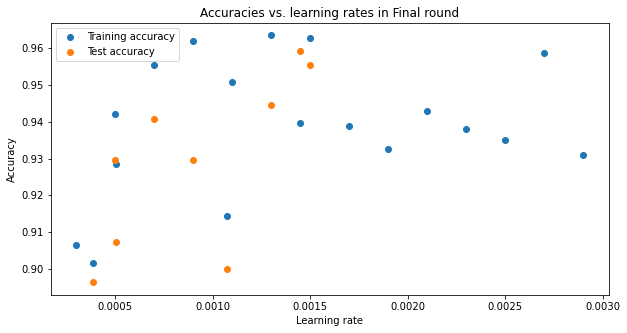

In [393]:
plt.figure(figsize=(10,5))

# Plotting values except for learning rates with highest accuracy
plt.scatter(adam_trials['Learning rate'], adam_trials['Accuracy'], label='Training accuracy')
plt.scatter(adam_trials['Learning rate'], adam_trials['Test accuracy'], label='Test accuracy')

# Plotting highest learning rate values
#plt.scatter(hyp_df['Learning rate'].iloc[:2], hyp_df['Accuracy'].iloc[:2], color='red')

# Annotating highest test accuracy
index = adam_trials['Test accuracy'].idxmax()
x1, y1 = adam_trials.iloc[index,:]['Learning rate'], adam_trials.iloc[index,:]['Test accuracy']

# getting coordinates of highest test accuracy
note = str(x1.round(5)) + ', \n' + str(y1.round(5))

# Creating dict of arguments for arrow and box
arrow_dict = {'facecolor':'black', 'shrink':0.05, 'lw':0.05, 'width':0.5}
bbox_dict = {'boxstyle':'round,pad=0.2', 'fc':'lightgray', 'ec':'black', 'lw':0.5}

# Annotating arrow and note in bbox
#plt.annotate(note, xy=(x1,y1), xytext=(0.0015, 0.75), arrowprops=arrow_dict,\
#            bbox=bbox_dict)

# Title and labels
plt.title('Accuracies vs. learning rates in Final round')
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### A maximum is established at a learning rate of 0.00025

## 5.0 Image Tuning

### 4.1 Standard Score Normalizing

In [394]:
# Subtracting image mean and image standard deviation from each individual image
mean = np.mean(images)
std = np.std(images)

X_adj = (images - mean)/std

In [395]:
# Splitting into train and (test, valid) sets to be split further
X_train_adj, X_test_val_adj, y_train_adj, y_test_val = train_test_split(X_adj, labels, test_size=0.3, random_state=132)

# Splitting (test, valid) set into seperate test and valid sets
X_test_adj, X_val_adj, y_test_adj, y_val_adj = train_test_split(X_test_val_adj, y_test_val, test_size=0.5, random_state=132)

In [396]:
# Confirming shapes
X_train_adj.shape, y_train_adj.shape

((1260, 200, 200, 1), (1260, 6))

In [397]:
# Confirming shapes
X_val_adj.shape, y_val_adj.shape

((270, 200, 200, 1), (270, 6))

In [398]:
# Cloning second model of final round to train on normalized data
norm_cnn = models.clone_model(second_2)

In [399]:
# Training normalized CNN
history_norm_cnn = train_model(norm_cnn, X_train_adj, y_train_adj, X_val_adj, y_val_adj)

TypeError: train_model() missing 1 required positional argument: 'checkpoint_path'

In [ ]:
# Confusion matrix Classification report for Normalized CNN model
predictor(norm_cnn, X_test_adj, y_test_adj)

In [ ]:
# Saving final model
norm_cnn.save('/Users/chinmayasukumar/Documents/Springboard/Capstone 3 - Metal defect detection/models/final_model')

### Models lost, tuner had to be reloaded from directory

In [ ]:
# Get n number of models from the tuner that was loaded in a list
def models_from_hp(tuner, n):
    hps = tuner.get_best_hyperparameters(n)
    return [tuner.hypermodel.build(hp) for hp in hps]

In [ ]:
# Instantiating models from tuner
first_rd_1, second_rd_1, third_rd_1, fourth_rd_1, fifth_rd_1 = models_from_hp(tuner_re, 5)

In [ ]:
# Loading weights from directory
def load_weights(model_dir, model):
    gen_path = '/Users/chinmayasukumar/Documents/Springboard/Capstone 3 - Metal defect detection/models/tuner_dir/Round 1/'
    return model.load_weights(gen_path + model_dir + '/checkpoint')

In [ ]:
# Loading weights from directory
load_weights('trial_04', first_rd_1);
load_weights('trial_08', second_rd_1);
load_weights('trial_03', third_rd_1);
load_weights('trial_02', fourth_rd_1);
load_weights('trial_09', fifth_rd_1);

### Models lost, tuner had to be reloaded from directory

In [ ]:
tuner_2_dir = '/Users/chinmayasukumar/Documents/Springboard/Capstone 3 - Metal defect detection/models/tuner_dir'
obj = "val_recall"
tuner_r2 = kt.RandomSearch(hypermodel=create_model_2, 
                           executions_per_trial=5,
                           overwrite=False, 
                           directory=tuner_2_dir,
                           project_name="Round 2");
tuner_r2.reload();

In [ ]:
# Get n number of models from the tuner that was loaded in a list
def models_from_hp(tuner, n):
    hps = tuner.get_best_hyperparameters(n)
    return [tuner.hypermodel.build(hp) for hp in hps]

In [ ]:
first_rd_2, second_rd_2, third_rd_2, fourth_rd_2, fifth_rd_2 = tuner_2.get_best_models(5)